# Project 1: Generative Adversarial Networks (GAN)

## by Xianghui Gu

## About this blog

Generative Adversarial Network (GAN) is a very popular semi-supervised learning model in recent years. It was first introduced by Ian Goodfellow in 2014. This blog is based on $\textit{NIPS 2016 Tutorial: Generative Adversarial Networks (Ian Goodfellow)}$ in general. The blog will introduce the background, application and principle of why it works. Furthermore, the blog will use MNIST to implement a simple GAN and also a trial of GAN application combined with autoencoder.

## 1. Background

Let's start with the name of this method. 'G' stands for generative modeling, 'A' stands for the adversarial training, and 'N' stands for the network where a piece of plain data turns into an almost-real data as expected. 

### 1.1 'G': Generative Modeling

A generative model is a model for randomly generating observable data values, typically given some hidden parameters. It specifies a joint probability distribution over observation and label sequences. Unlike discrimitive modeling which learns $p(x|z)$, generative modeling focus more on $p(x,z).$

![title](discriminative_vs_generative.png)

(Source: https://duphan.wordpress.com/tag/generative-model/)

There are many reasons to apply generative modeling. Its advantages include:
- can represent and manipulate high-dimensional probability distributions
- can be trained with missing data and can provide predictions on inputs that are missing data
- can work with multi-modal outputs
- can generate realistic samples from some distribution

### 1.2 'A': Adversarial Training & Minimax Game

The idea of Adversarial Training has a counterpart in game theory, called minimax game. The goal is minimizing the score of opponent as well as maximizing self's score. 

$$\Theta^{(G)*}=\arg\min_{\Theta^{(G)}} \max_{\Theta^{(D)}} V(\Theta^{(D)},\Theta^{(G)})$$

Similarly, Adversarial Training in GAN is like two opponents compete with each other in the training model. Imagine a game between two players. One of them is called $G$ (the $generator$). $G$ creates samples that are intended to come from the same distribution as the training data. The other player is called $D$ (the $discriminator$). $D$ examines samples to determine whether they are real or fake. $D$ learns using traditional supervised learning techniques, dividing inputs into two classes (real or fake). $G$ is trained to fool $D$. The goal of $G$ is to make $D$ behaves like guessing instead of classifying the data.


A classic way of thinking this game: $G$ is a counterfeiter, trying to make fake money, and $D$ is a cop , trying to allow real money and catch fake money. To succeed in this game, $G$ must learn to make fake money that is indistinguishable from real money.

### 1.3 'N': Neural Network

GAN combines neural network with generative modeling and adversarial training. In general, both $D$ and $G$ have their own neural network: one for classifying real and fake data, one for making fake data look real.

## 2. Applications

GAN has a wide range of applications. Here we introduce two applications on images.

### 2.1 Image Generation from AIR

A bunch of noise can be turned into an image we want under the magic of generator. The figure below is a set of cute outputs generated by $G$ trained on animation datasets.

![title](loli.png)

(Source: https://github.com/mattya/chainer-DCGAN)

### 2.2 Image Arithmetics

The trials on feature vector arithmetics shows a rich linear structure in representation space. Further exploring and developing vector arithmetic could dramatically reduce the amount of data needed for conditional generative modeling of complex image distributions. The figure below illustrates how to make a "smiling man" from "similing woman", "neutral woman" and "neutral man".

![title](faces.png)

(Source: Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, by
Alec Radford, Luke Metz, Soumith Chintala)

## 3. Principle of GAN: How it works

In the background part, we offer a general idea of the components of GAN. In this section, we'll talk more about how GAN works.

- $\textbf{Basic idea}$

GAN is the relection of adversarial thinking in neural network. It includes two neural networks. One is the Generator network, which aims at making fake data look real; the other is the Discriminator network, which aims at telling the difference with fake data from the real data. The latter outputs a number between 0 and 1, which stands for the probability that input is from real data. For instance, the ouput 1 stands for real data, and 0 stands for fake data. In theory, with the convergence of training, each piece of data generated by the Generator network should be "hard" enough for the Discriminator network to decide whether real or not. Hence, the output of the latter should be 0.5.

The figure below illustrates the task of $D$ (Discriminator network) and $G$ (Generator network) in GAN.

![title](d_g.png)

(Source: NIPS 2016 Tutorial: Generative Adversarial Networks, by Ian Goodfellow)

- $\textbf{Objective}$

Given the real data $x$ and fake data $z$, the goal is to maximize $V_D,V_G$ for $D$ and $G$ respectively. The goals used in the training network are:

$$V_D=\log(D(x))+\log(1−D(G(z)))$$
$$V_G=\log(D(G(z)))$$

The reason why the goals are not "symmetric" is that in $V_G=\log(D(G(z)))+\log(1-D(x))$, the second term has nothing to do with $G$, hence omitted in maximization for simplicity.

## 4. Toy Examples of GAN on MNIST

The toy examples are mainly inspired by $\textit{Generative Adversarial Nets in TensorFlow}$ (by Eric Jang) and Nathan Lintz's implementation.

(Source: https://github.com/nlintz/TensorFlow-Tutorials/blob/master)

(Source: http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html)

### 4.1 One hidden layer implementation with 200 neurons

In [26]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Here we use the MNIST data from tensorflow tutorial, whose size is (55000, 784).

In [27]:
mnist = input_data.read_data_sets("MNIST_data/")
images = mnist.train.images

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


- $\textbf{Weight Initialization by Xavier}$

For other distribution initialization (such as normal distribution), the neural network may perform bad or even fail due to trivial weight or exploding weight.

For example, I tried normal distribution in this setting, the numpy returns error: 

$\textit{UserWarning: Warning: converting a masked element to nan.}$

Hence, Xavier distribution is suitable in this situation. Andy's blog introduces $\textbf{Xavier initialization}$ which help signals reach deep into the network.

If the weights in a network start too small, then the signal shrinks as it passes through each layer until it’s too tiny to be useful.
If the weights in a network start too large, then the signal grows as it passes through each layer until it’s too massive to be useful.
Xavier initialization makes sure the weights are ‘just right’, keeping the signal in a reasonable range of values through many layers.

(Source: http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)

In [63]:
def xavier_initializer(shape):
    return tf.random_normal(shape=shape, stddev=1/shape[0])

- $\textbf{MLP setting}$

Here we set the components in MLP (multi-layer perceptrons). There are two set of parameters: one set for $D$ and one for $G$. The neurons are set to be 200.

In [64]:
one_layer = 200

Generator parameters: take 128 latent variables as the noise source for generating fake figures (28*28)

In [65]:
z_size = 128
g_output_size = 784

Disciminator parameters: try to detect whether the input figure of 28*28 is real or fake (output: 1/0)

In [66]:
x_size = 784
d_output_size = 1

Eric Jang's blog put all the parameters in a function. For debugging purpose, we don't follow it here. We write the weights and their initialization globally as Nathan did, so that we can detect exploding weights. $w_i$ stands for the coefficients corresponding to each node, while $b_i$ stands for the offset. 

In [67]:
g_weights = {
    'w1': tf.Variable(xavier_initializer(shape=(z_size, one_layer))),
    'b1': tf.Variable(tf.zeros(shape=[one_layer])),
    'w2': tf.Variable(xavier_initializer(shape=(one_layer, g_output_size))),
    'b2': tf.Variable(tf.zeros(shape=[g_output_size]))
}

d_weights ={
    'w1': tf.Variable(xavier_initializer(shape=(x_size, one_layer))),
    'b1': tf.Variable(tf.zeros(shape=[one_layer])),
    'w2': tf.Variable(xavier_initializer(shape=(one_layer, d_output_size))),
    'b2': tf.Variable(tf.zeros(shape=[d_output_size]))
}

Now we write out the neural network model. $l_i$ stands for the temporary result after computing $i^{th}$ layer. We use tanh here as did in Eric Jang's blog, but use sigmoid to control the answer in range of 1.

In [68]:
def Gen(z, w=g_weights):
    l1 = tf.nn.tanh(tf.matmul(z, w['w1']) + w['b1'])
    return tf.sigmoid(tf.matmul(l1, w['w2']) + w['b2'])

def Dis(x, w=d_weights):
    l1 = tf.nn.tanh(tf.matmul(x, w['w1']) + w['b1'])
    return tf.sigmoid(tf.matmul(l1, w['w2']) + w['b2'])

Now, it's time to prepare for the input and output of the MLP model. We use placeholder $d_{input}$ and $g_{input}$ to hold the input size for neural network of $D$ and $G$ respectively. Since we don't know how many instances to generate or to test, we set the row parameter to $None$. The output of $G$ is obtained by applying function $\textit{Gen}$ directly on latent vector $z$.

In [69]:
d_input = tf.placeholder('float', shape=(None, x_size))
g_input = tf.placeholder('float', shape=(None, z_size))
g_output = Gen(g_input)

- $\textbf{Objective of D and G}$

The objective function for $D$ and $G$ are:
$$\max V_D=\log(D(x))+\log(1−D(G(z)))$$
$$\max V_G=\log(D(G(z)))$$
Hence, within a batch, we take the mean of all the scores as a standard. 

In [70]:
G_objective = tf.reduce_mean(tf.log(Dis(Gen(g_input))))
D_objective = tf.reduce_mean(tf.log(Dis(d_input)) + tf.log(1 - Dis(Gen(g_input))))

Eric Jang uses momentum_optimizer to minimize the objective. It is flexible to modify the learning rate and step, but complicated. For simplicity, this blog uses AdamOptimizer to find optimum as Nathan did. Note the objective should be negative since we are maximizing the objective function.

In [71]:
G_opt = tf.train.AdamOptimizer().minimize(-G_objective, var_list=g_weights.values())
D_opt = tf.train.AdamOptimizer().minimize(-D_objective, var_list=d_weights.values())

- $\textbf{Run the model and plot samples}$

Here we use epoch of 30,000 and batch size of 128. As suggested in Eric Jang's blog, $D$ might need more rounds to learn in case $G$ learns too fast. For simplicity, we keep $D_{rounds}=1$ for the time being.

In [72]:
import tqdm

epochs = 30000
batch_size = 128

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

D_rounds = 1

for _ in tqdm.tqdm(range(epochs)):
    sess.run(G_opt, {
        g_input: np.random.normal(size=(batch_size, z_size))           
    })
    for _ in range(D_rounds):
        sess.run(D_opt, {
            d_input: images[np.random.choice(range(len(images)), batch_size)].reshape(batch_size, x_size),
            g_input: np.random.normal(size=(batch_size, z_size))
        })

100%|██████████| 30000/30000 [13:20<00:00, 40.04it/s]


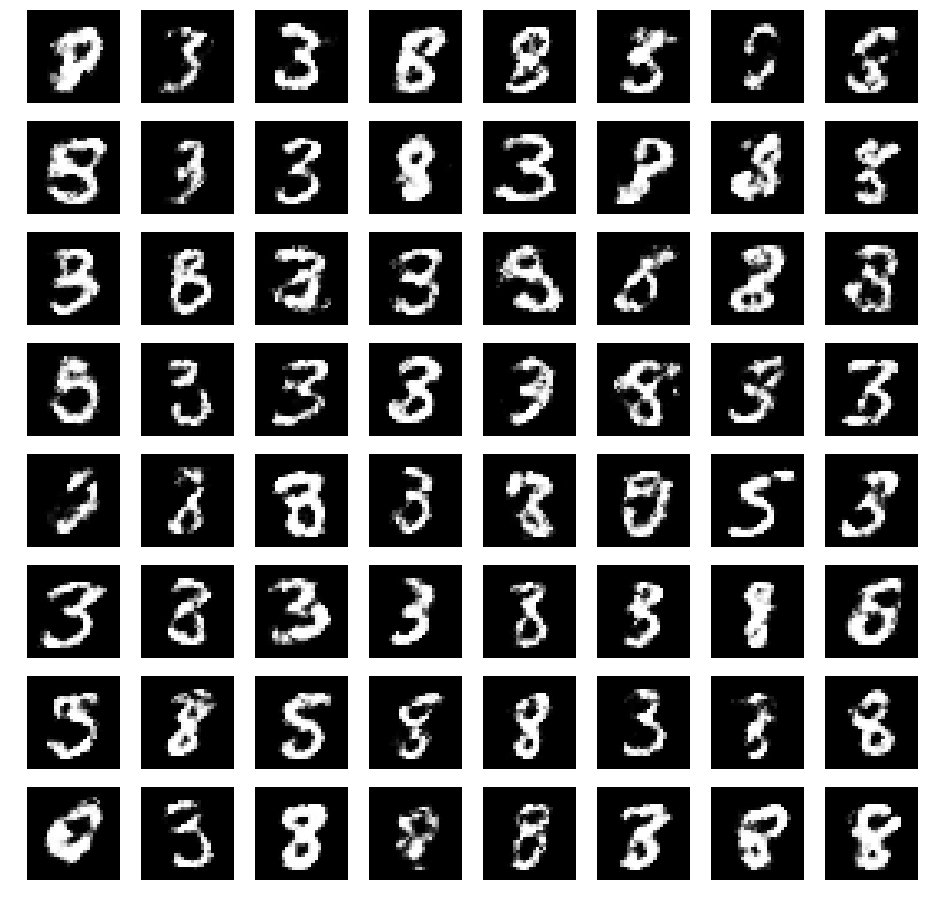

In [73]:
import math
samples = 64
side = int(math.sqrt(samples))

fakes = sess.run(g_output,{g_input:np.random.normal(size=(samples, z_size))})

plt.figure(figsize=(16,16))

for i in range(samples):
    plt.subplot(side,side,i+1)
    fake = fakes[i,:]
    plt.imshow(fake.reshape(28, 28), cmap='gray')
    plt.axis("off")

As can be seen from the figure above, the most numbers look like 3 and 8, and there are some 2 and 5. Under this settings, 3 and 8 have a large domain in the space implied by the neural network. More sampling and training may help generate more numbers.

### 4.2 Two hidden layer implementation with 100 neurons for each layer

To see whether more perceptrons work better or more layers work better in GAN, we made a second toy example using two hidden layers with 100 neurons each.

In [6]:
first_layer = 100
second_layer = 100

Accordingly, the weights and the models are modified.

In [7]:
g_weights = {
    'w1': tf.Variable(xavier_initializer(shape=(z_size, first_layer))),
    'b1': tf.Variable(tf.zeros(shape=[first_layer])),
    'w2': tf.Variable(xavier_initializer(shape=(first_layer, second_layer))),
    'b2': tf.Variable(tf.zeros(shape=[second_layer])),
    'w3': tf.Variable(xavier_initializer(shape=(second_layer, g_output_size))),
    'b3': tf.Variable(tf.zeros(shape=[g_output_size]))
}

d_weights ={
    'w1': tf.Variable(xavier_initializer(shape=(x_size, first_layer))),
    'b1': tf.Variable(tf.zeros(shape=[first_layer])),
    'w2': tf.Variable(xavier_initializer(shape=(first_layer, second_layer))),
    'b2': tf.Variable(tf.zeros(shape=[second_layer])),
    'w3': tf.Variable(xavier_initializer(shape=(second_layer, d_output_size))),
    'b3': tf.Variable(tf.zeros(shape=[d_output_size]))
}

def Gen(z, w=g_weights):
    l1 = tf.nn.tanh(tf.matmul(z, w['w1']) + w['b1'])
    l2 = tf.nn.tanh(tf.matmul(l1, w['w2']) + w['b2'])
    return tf.sigmoid(tf.matmul(l2, w['w3']) + w['b3'])

def Dis(x, w=d_weights):
    l1 = tf.nn.tanh(tf.matmul(x, w['w1']) + w['b1'])
    l2 = tf.nn.tanh(tf.matmul(l1, w['w2']) + w['b2'])
    return tf.sigmoid(tf.matmul(l2, w['w3']) + w['b3'])

The other part of MLP modeling is the same. Let's have a quick review:

In [8]:
d_input = tf.placeholder('float', shape=(None, x_size))
g_input = tf.placeholder('float', shape=(None, z_size))
g_output = Gen(g_input)


In [9]:
G_objective = tf.reduce_mean(tf.log(Dis(Gen(g_input))))
D_objective = tf.reduce_mean(tf.log(Dis(d_input)) + tf.log(1 - Dis(Gen(g_input))))

In [10]:
G_opt = tf.train.AdamOptimizer().minimize(-G_objective, var_list=g_weights.values())
D_opt = tf.train.AdamOptimizer().minimize(-D_objective, var_list=d_weights.values())

In [12]:
import tqdm
epochs = 30000
batch_size = 128

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

D_rounds = 1

for _ in tqdm.tqdm(range(epochs)):
    sess.run(G_opt, {
        g_input: np.random.normal(size=(batch_size, z_size))           
    })
    for _ in range(D_rounds):
        sess.run(D_opt, {
            d_input: images[np.random.choice(range(len(images)), batch_size)].reshape(batch_size, x_size),
            g_input: np.random.normal(size=(batch_size, z_size))
        })

100%|██████████| 30000/30000 [10:19<00:00, 48.39it/s]


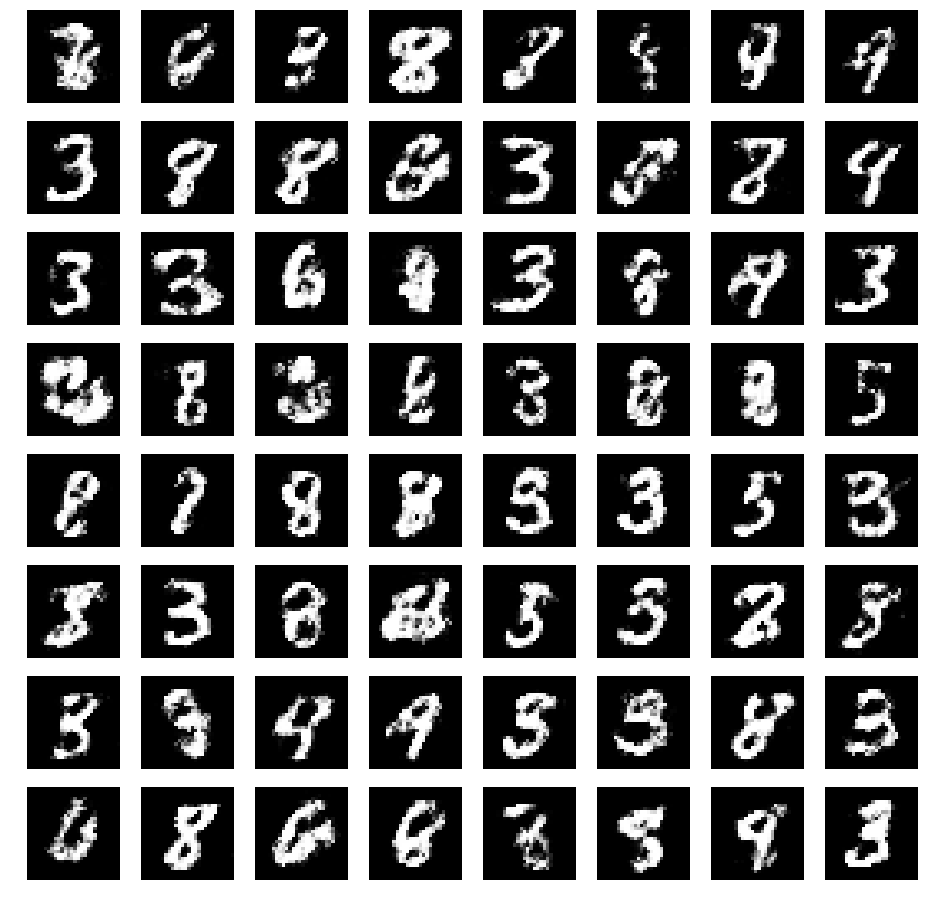

In [17]:
import math
samples = 64
side = int(math.sqrt(samples))

fakes = sess.run(g_output,{g_input:np.random.normal(size=(samples, z_size))})

plt.figure(figsize=(16,16))

for i in range(samples):
    plt.subplot(side,side,i+1)
    fake = fakes[i,:]
    plt.imshow(fake.reshape(28, 28), cmap='gray')
    plt.axis("off")

As can be seen from the figure above, we can tell 1,2,3,4,5,7,8,9. It seems like two layer works better than one layer given the same number of hidden neurons.

### 4.3 Combination of autoencoder and GAN

Speaking of self-supervising machine learning algorithms, it reminds me of autoencoder building. Autoencoder can extract the features of an image, and compress the information by encoding. If we change the real input into encoded (compressed) images, will GAN learn faster or generate better output since features have already been summarized? If it will, it may be a good idea that GAN generates an encoded image and in turn decoder reconstructs it.

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

- $\textbf{Set and build autoencoder}$

Let's start with building an autoencoder on keras workframe. For simplicity, we train and test the autoencoder by keras MNIST datasets. The building of autoencoder is based on keras tutorial.
(Source: https://blog.keras.io/building-autoencoders-in-keras.html)

In [4]:
from keras.datasets import mnist
(x_train, label_train), (x_test, label_test) = mnist.load_data()

Reshape the train/test images into (60000, 28, 28, 1) and (10000, 28, 28, 1) respectively.

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

The autoencoder takes the original image as input, which is (28,28,1). The encoded message is (4,4,8) which is 128-dimensional. The decoded message should have the same dimension as the input. Due to the learning rate of autoencoder and computational resource, we use 20% of the training set and full testing test as validation. The epoch is set to be 20.

In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)


autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# select 10% for training
small_ratio = 0.2
small_ind = np.random.choice(len(x_train), int(len(x_train)*small_ratio), replace = False)

x_train_small = x_train[small_ind]

history = autoencoder.fit(x_train_small, x_train_small,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 12000 samples, validate on 10000 samples
Epoch 1/20
12000/12000 [==============================] - 21s - loss: 0.3975 - val_loss: 0.2649
Epoch 2/20
12000/12000 [==============================] - 21s - loss: 0.2397 - val_loss: 0.2233
Epoch 3/20
12000/12000 [==============================] - 21s - loss: 0.2194 - val_loss: 0.2123
Epoch 4/20
12000/12000 [==============================] - 21s - loss: 0.2051 - val_loss: 0.1938
Epoch 5/20
12000/12000 [==============================] - 20s - loss: 0.1904 - val_loss: 0.1832
Epoch 6/20
12000/12000 [==============================] - 22s - loss: 0.1811 - val_loss: 0.1747
Epoch 7/20
12000/12000 [==============================] - 22s - loss: 0.1748 - val_loss: 0.1729
Epoch 8/20
12000/12000 [==============================] - 24s - loss: 0.1697 - val_loss: 0.1713
Epoch 9/20
12000/12000 [==============================] - 22s - loss: 0.1661 - val_loss: 0.1602
Epoch 10/20
12000/12000 [==============================] - 23s - loss: 0.1622 - val_lo

Build the model of encoding original images

In [7]:
encoder = Model(input_img, encoded)

We encode the first image in the training dataset as an example.

In [8]:
encode_sample = encoder.predict(x_train[0:1])

Check the shape is (4,4,8). Then, we can have a sight of how encoded images look like (here we reshape the encoded image into 16*8)

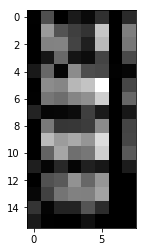

In [9]:
plt.imshow(encode_sample.reshape(16,8),cmap="gray")

So far I didn't find a nice way to formulate the decoder from encoded message. Let's do it in brutal force.

In [11]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(4,4,8))
# retrieve the layer of the autoencoder model
temp = autoencoder.layers
# create the decoder model
decoder = Model(encoded_input, temp[-1](temp[-2](temp[-3](temp[-4](temp[-5](temp[-6](temp[-7](encoded_input))))))))

Visualize the decoded image from encoded message:

In [12]:
decode_sample = decoder.predict(encode_sample)

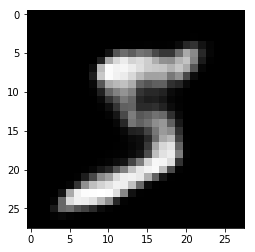

In [13]:
plt.imshow(decode_sample.reshape(28,28),cmap="gray")

Compared with the original message, we can find the character looks dimmer, which may be attributed to loss in encoding/decoding.

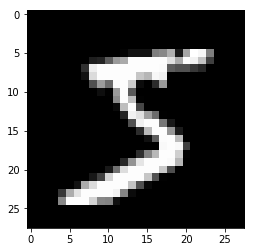

In [15]:
plt.imshow(x_train[0].reshape(28,28),cmap="gray")

- $\textbf{GAN using encoded images with one hidden layer of 200 neurons}$

For comparison, we directly use the foundation in Toy example 4.1, which is one hidden layer with 200 neurons. Let's have a quick review.

In [16]:
one_layer = 200

z_size = 128
g_output_size = 128

x_size = 128
d_output_size = 1

In [19]:
g_weights = {
    'w1': tf.Variable(xavier_initializer(shape=(z_size, one_layer))),
    'b1': tf.Variable(tf.zeros(shape=[one_layer])),
    'w2': tf.Variable(xavier_initializer(shape=(one_layer, g_output_size))),
    'b2': tf.Variable(tf.zeros(shape=[g_output_size]))
}

d_weights ={
    'w1': tf.Variable(xavier_initializer(shape=(x_size, one_layer))),
    'b1': tf.Variable(tf.zeros(shape=[one_layer])),
    'w2': tf.Variable(xavier_initializer(shape=(one_layer, d_output_size))),
    'b2': tf.Variable(tf.zeros(shape=[d_output_size]))
}

In [20]:
def Gen(z, w=g_weights):
    l1 = tf.nn.tanh(tf.matmul(z, w['w1']) + w['b1'])
    return tf.sigmoid(tf.matmul(l1, w['w2']) + w['b2'])

def Dis(x, w=d_weights):
    l1 = tf.nn.tanh(tf.matmul(x, w['w1']) + w['b1'])
    return tf.sigmoid(tf.matmul(l1, w['w2']) + w['b2'])

In [21]:
d_input = tf.placeholder('float', shape=(None, x_size))
g_input = tf.placeholder('float', shape=(None, z_size))
g_output = Gen(g_input)

In [22]:
G_objective = tf.reduce_mean(tf.log(Dis(Gen(g_input))))
D_objective = tf.reduce_mean(tf.log(Dis(d_input)) + tf.log(1 - Dis(Gen(g_input))))

In [23]:
G_opt = tf.train.AdamOptimizer().minimize(-G_objective, var_list=g_weights.values())
D_opt = tf.train.AdamOptimizer().minimize(-D_objective, var_list=d_weights.values())

Encode the dataset and forge into the size of input

In [30]:
enc_images = encoder.predict(images.reshape(len(images),28,28,1)).reshape(len(images),g_output_size)

In [34]:
enc_images.shape

(55000, 128)

Train the GAN using the encoded message

In [39]:
sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [49]:
import tqdm
epochs = 30000
batch_size = 128

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

D_rounds = 1

for _ in tqdm.tqdm(range(epochs)):
    sess.run(G_opt, {
        g_input: np.random.normal(size=(batch_size, z_size))           
    })
    for _ in range(D_rounds):
        sess.run(D_opt, {
            d_input: enc_images[np.random.choice(range(len(enc_images)), batch_size)].reshape(batch_size, x_size),
            g_input: np.random.normal(size=(batch_size, z_size))
        })

100%|██████████| 30000/30000 [07:00<00:00, 71.31it/s]


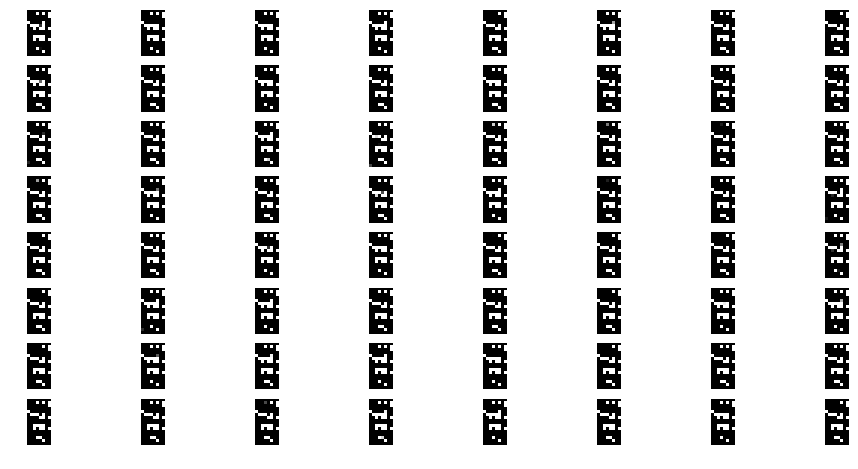

In [53]:
import math
sample_size = 64
dim = (int(math.sqrt(sample_size)),int(math.sqrt(sample_size)))
plt.figure(figsize=(16,8))
img = sess.run(g_output, {g_input: np.random.normal(size=(sample_size, z_size))})
img_mat = np.empty([sample_size, g_output_size])

for i in range(sample_size):
    plt.subplot(dim[0],dim[1],i+1)
    image = img[i,:]
    img_mat[i,:] = image
    plt.imshow(image.reshape(16, 8), cmap='gray')
    plt.axis("off")

In [54]:
xxx = decoder.predict(img_mat.reshape(len(img_mat),4,4,8))

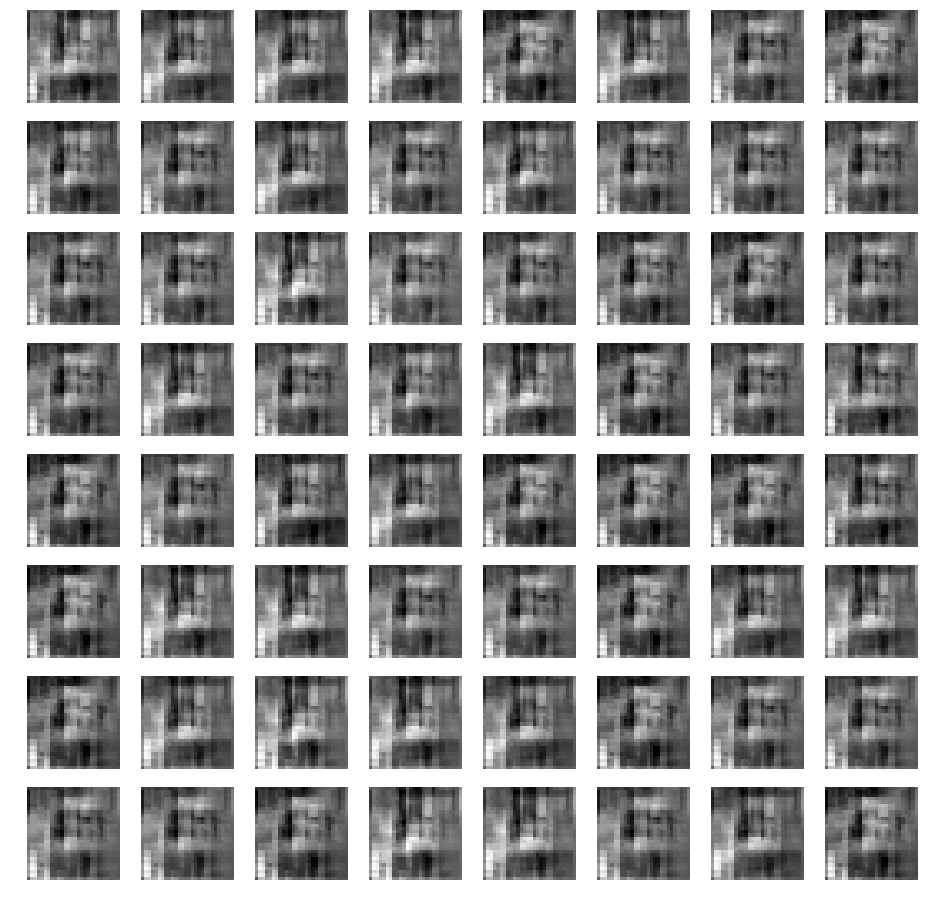

In [55]:
plt.figure(figsize=(16,16))
for i in range(sample_size):
    plt.subplot(dim[0],dim[1],i+1)
    image = xxx[i,:]
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.axis("off")

As can be seen from the figure above, the combination of GAN and autoencoder didn't work as expected. This may due to the double error from encoding/decoding as well as from GAN. Since we control the GAN part compared with Toy example 4.1, the error from autoencoder might be the main cause.

To confirm, let's try epochs = 50,000.

In [56]:
import tqdm
epochs = 50000
batch_size = 128

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

D_rounds = 1

for _ in tqdm.tqdm(range(epochs)):
    sess.run(G_opt, {
        g_input: np.random.normal(size=(batch_size, z_size))           
    })
    for _ in range(D_rounds):
        sess.run(D_opt, {
            d_input: enc_images[np.random.choice(range(len(enc_images)), batch_size)].reshape(batch_size, x_size),
            g_input: np.random.normal(size=(batch_size, z_size))
        })

100%|██████████| 50000/50000 [12:10<00:00, 68.44it/s]


In [59]:
import math
img2 = sess.run(g_output, {g_input: np.random.normal(size=(sample_size, z_size))})
img_mat2 = np.empty([sample_size, g_output_size])

for i in range(sample_size):
    image = img2[i,:]
    img_mat2[i,:] = image


In [60]:
yyy = decoder.predict(img_mat2.reshape(len(img_mat),4,4,8))

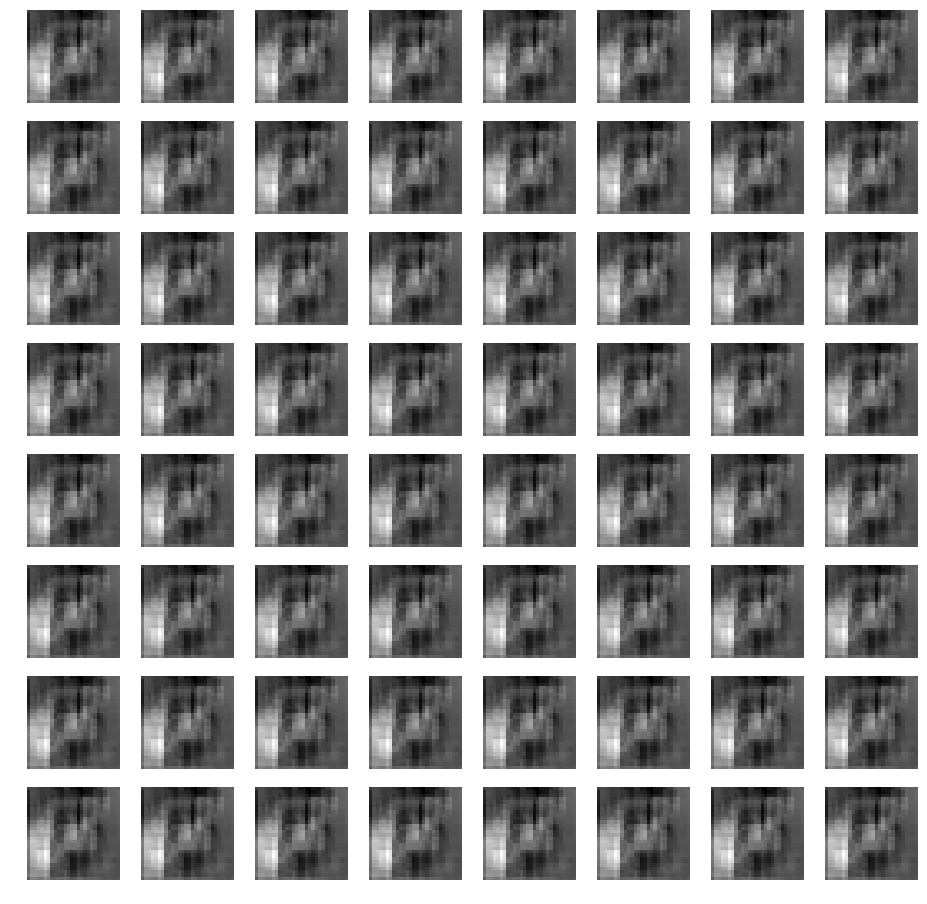

In [61]:
plt.figure(figsize=(16,16))
for i in range(sample_size):
    plt.subplot(dim[0],dim[1],i+1)
    image = yyy[i,:]
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.axis("off")

The figure displayed shows it is far from convergence. Hence, encoding in such compression ratio did not perform well combined with GAN.

### 5. Discussion and Conclusion

Through the explanation and implementation of GAN, I hope you can have a general idea of GAN. It is useful and powerful, and has many fun and profitable applications. In addition to the trials displayed in the blog, I've run several rounds with different parameters. The thoughts are summarized below.

- With small number of epochs, the output almost looks the same. One can't discriminate the number (it looks like the combination of all digits).

- Due to compuational resources, I didn't try a wide range of additional rounds for $D$ ($D$ may be trained more rounds than $G$ to prevent that $G$ grows faster.) Under the settings in the blog, I didn't tell the difference between $D_{rounds}=1$ and $D_{rounds}=5$. Also, more neurons and more layers might help generating clearer digits.

- It's hard to pick the right set of MLP parameters, initialization distributions and epochs. Any improper parameter can lead to exploding weights.

- From Toy example 4.1 and 4.2, under this set of parameters, two layer model performs better than one layer model given the same number of neurons in GAN. Additional layer may consider more nonlinear relationship than just one layer, which might be the cause for better performance. 

- From Toy example 4.3, the combination of encoding/decoding and GAN might be too brutal. The error from encoding/decoding and GAN can both harm the performance of generating digits. The paper, $\textit{Adversarial Autoencoders}$ (by Alireza Makhzani, Jonathon Shlens, Navdeep Jaitly, Ian Goodfellow, Brendan Frey), introduces combination of VAE decoder and GAN which has a much better performance.    (Source: https://arxiv.org/pdf/1511.05644)